I love music. I really do. I spend a ton of time listening to music on Spotify and YouTube (even Amazon when I have to). I listen to music at home, at work, at the gym, everywhere. One of my favourite things is discovering new music and one of my few claims to fame is having a ton of 8tracks followers back in the day when 8tracks was still a thing - for real, [check my old account out](https://8tracks.com/samandhiskazoo). Just like me on 8tracks, Spotify also does a pretty good job of creating playlists with music I like, and YouTube's algorithm every so often will start pushing a song in my recommendations that I end up really liking. However, sometimes I'm just in a mood and I want to listen to <i>a type</i> of music. Spotify and YouTube kinda fail there. That got me thinking, what if I could take a whole bunch of songs and their audio features and then put those songs into playlists that have other songs with similar features. If I could do that, I could take the playlists and filter on the audio features I want. Luckily for everyone who cares about this, by using a k-means clustering algorithm and the Spotify API to download song features I was able to do just that. Throughout this article I'll be talking about playlists and clusters somewhat interchangeably, since by the end of this, each cluster will represent a unique playlist.

The first step was to decide on a list of songs I want to group into playlists. There is a massive universe of songs so I decided to only use weekly Billboard top 100 hits from 1998 to end of 2018. Once I had my list of songs, I used the Spotify API to get a list of [song features](https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/). I developed a function that took the track name and artist name and then searched Spotify for the unique song ID which I could then use to get the music features. I immediately noticed that this function was failing a lot of the time. Upon further investigation, I found almost all of the problems were from songs featuring multiple artists - for example "Wolves by Marshmello featuring Selena Gomez" wouldn't get picked up by Spotify since Spotify had the song as "Wolves by Marshmello." Once I figured this out I simply removed any mention of featured artists and cleaned up weird symbols (if you're interested, you can check out the [function](https://github.com/sampurkiss/song_features/blob/master/charts_analyzer.py)). Once I did this, Spotify could identify over 90% of the songs from my list and attach a unique identifier code to them. Getting Spotify's unique identifier was crucial for getting the music features.

In [1]:
import pandas as pd
import numpy as np
import qgrid
import matplotlib.pyplot as plt
from cost_and_grad import compute_cost, compute_grad
import clustering_algorithms
billboard_charts_2000_on = pd.read_csv('https://raw.githubusercontent.com/sampurkiss/song_features/master/song_details.csv')

So now I have a database of all songs that made it on Billboard's weekly top 100 and each songs audio features. Now it's time to do some data exploration. First off, I was curious if we can see any change over time in what songs are making the charts. I converted the key variable, currently just a number representing a key, to the name of the key and then plotted the relative number of each over time. The below chart shows the percentage of songs in each key over time. It's easy to see there are periods where certain keys are more popular and that some keys like D# are never that popular. For a bit of context on keys you can search for songs by key [here](https://www.songkeyfinder.com/). 

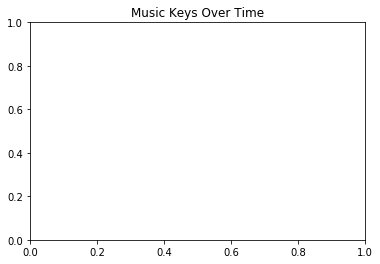

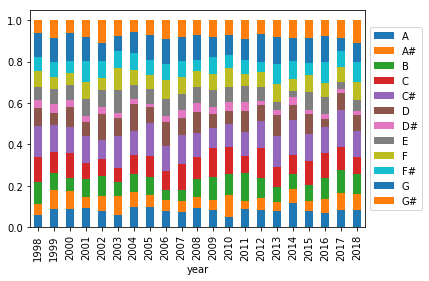

In [2]:
keys = []
for i in billboard_charts_2000_on['key'].dropna():
    if i not in keys:
        keys.append(i)
keys.sort()
key_dict = {"0":"C","1":"C#","2":"D","3":"D#",
        "4":"E","5":"F","6":"F#","7":"G" ,"8":"G#",	
        "9":"A","10":'A#','11':'B'}
temp = billboard_charts_2000_on.copy()
temp['num_of_songs'] = 1
temp.loc[:,'key'] = temp.loc[:,'key'].map(lambda x: key_dict[str(int(x))])
temp = temp[['year','key','num_of_songs']].groupby(by =['year','key']).sum().reset_index()
temp = temp.pivot(index='year',columns = 'key',values = 'num_of_songs')
temp = temp.div(temp.sum(axis=1),axis=0)
plt.title('Music Keys Over Time')
temp.plot.bar(stacked=True, legend =False)
plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

I wanted to look for more than just key changes because, let's be honest, even though the above graph is kind of interesting, it doesn't have a lot of practical meaning if you're not a professional musician. I also decided to look at average values of a few different features over time. 

The first graph shows energy, danceability and valence. From Spotify: 
Energy is a measure from 0 to 1 and represents a measure of intensity and activity. High energy tracks feel loud and noisy, low energy tracks are the opposite.
Danceability measures how suitable a song is for dancing based on several different measures. 1 means high danceability, 0 means no danceability.
Valence describes musical cheerfulness of a song measured between 0 and 1. High valence means the song feels really positive and happy. 

As you can see, valence has been steadily decreasing since 2000 which I guess means that popular music is getting steadily more depressing and angry over time? Perhaps we can blame Adele's Hello and most Billie Eilish songs for that. Oddly enough danceability and energy seem to move in opposite directions which would indicate that danceability isn't heavily tied to energy. As an economist, I was kinda hoping to see some movement around recessionary periods, eg. after 2008 in the peak of the recession, I thought popular music might have gotten more depressing, or valence might have initially decreased and then increases as the economy recovers. That doesn't appear to be happening but I think it's an interesting point for future research.

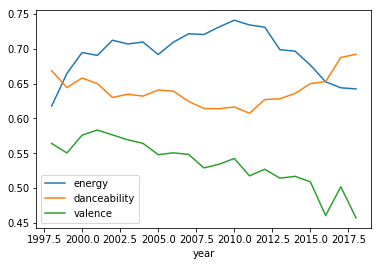

In [3]:
temp = billboard_charts_2000_on[['year','energy','danceability','valence']].groupby(by='year').mean()
temp.plot.line()

This next chart shows a few more features over time, mostly related to music/lyrical qualities. There are some interesting patterns here which I would encourage looking into. What's particularly interesting are the peaks and troughs.  

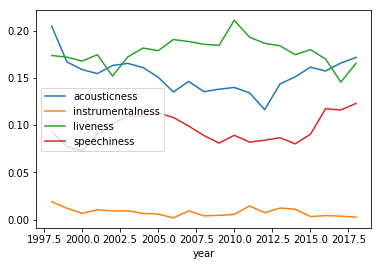

In [4]:
temp = billboard_charts_2000_on[['year','acousticness','instrumentalness','liveness','speechiness']].groupby(by='year').mean()
temp.plot.line()

Finally, I restricted the dataset to just the features I was interested in. I kept one dataset in pandas form and converted one to numpy to run the clustering algorithms on. That way, once I've assigned a cluster to each song I can attach the cluster number to the dataset and from there I can easily look through the data to see what songs have been clustered together.
I included most features except for the key variable. When trying to create these playlists, it didn't really matter to me whether the songs were in the same key.

In [5]:
charts = billboard_charts_2000_on[['Song','Performer','track_id',
                              'danceability', 'energy',
                              'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                              'instrumentalness', 'liveness', 'valence', 'tempo', 
                              'time_signature']].reset_index(drop=True).copy()

#Because songs show up multiple times, must eliminate duplicates, also remove any nas.
charts = charts.drop_duplicates()
charts = charts.dropna()
name_matrix = charts

X = charts[['danceability', 'energy',
                              'key', 'loudness', 'mode', 'speechiness', 'acousticness',
                              'instrumentalness', 'liveness', 'valence', 'tempo', 
                              'time_signature']].copy()
X = np.matrix(X)

Now that I have my data table, I want to normalize all the features. In this case I'm normalizing to a mean 0 and dividing by the largest number in each feature range. 

In [6]:
def normalize_values(X,use_sigma=True):
    """
    Normalizes the values of X. Can either normalize
    by dividing each feature vector by its respective standard 
    deviation or by the max value in the respective vector.
    Parameters:        
        X: a numpy matrix with dataset of interest
        use_sigma: whether to normalize using sigma
        (True) or by the largest number in the feature 
        vector (False)
    Returns:
        X_normalized: X values normalized based off the 
        decided setting
    """
    m,features = X.shape
    mu = sum(X)/m
    if use_sigma:
        divisor = np.sqrt(sum(np.square(X-mu))/m)
    else:
        divisor = np.max(X,axis=0)
    X_normalized = np.divide((X-mu),divisor)
    return X_normalized

X = normalize_values(X,use_sigma=False)

Now that my features are normalized I can run the clustering algorithm. The first step is choosing the number of clusters and initializing the clusters by picking points at random to start from. At this point I have over 6,000 songs to pick from so I decided to go with 300 clusters to make sure I have a good number of playlists that aren't too long. I can initialize the clusters by picking 300 different songs which I will use as starting points. When you're picking these songs, one of the most important things is to make sure you're picking without replacement (i.e. you're not picking the same song as a starting point more than once).

In [7]:
def initialize_centroids(X, k):
    """
    Used to select a starting point for centroids. Algorithm
    selects k data points from X and returns the centroid values 
    and location in the index
    paramaters:
        X: a numpy matrix with the dataset of interest
        k: number of centroids to initialize
    Returns:
        centroids, cluster_index
    """
    m,features = X.shape
    initial_centroids = np.random.choice(range(0,m),k,replace=False)
    centroids = X[initial_centroids]
    cluster_index = np.array(range(0,k))
    
    return centroids, cluster_index

#define number of clusters and generate starting point:
k = 300
centroids, cluster_allocation = initialize_centroids(X, k)  

Now we can actually run the clustering process. I have two functions, one that calculates the next cluster location and one that calculates the cost function.

In [8]:
def generate_centroids(X, index_location_of_centroids, k):
    """
    Takes existing allocation of centroids and calculates the
    next centroid value. Specifically, it calculates the average
    location of all X values allocated to each centroid, and 
    returns that as the new centroid.
    Parameters:
        X: a numpy index of values
        index_location_of_centroids: an index of values that 
        indicates which centroid each row in X belongs to
        k: number of centroids
        
    Returns:
        cluster_each_x_belongs_to: the updated values 
        for index_location_of_centroids
        new_centroids: the new centroid values
        
    Note: initial_centroids should be organized in order of
    cluster it belongs to (e.g. centroid 0 should correspond
    to initial_centroids[0])
    """    
    #Generate variables:
    [m,features] = X.shape
    cluster_each_x_belongs_to =np.array([],dtype='int')
    new_centroids = np.zeros((k,features))
    
    for i in range(0,k):
        #get average "location" of each cluster
        new_centroids[i,:] = X[np.where(index_location_of_centroids==i),:].mean(axis=1)

    #Generate index value corresponding to the new centroid value
    for row in X:
        distance = np.sum(np.square(row-new_centroids),axis =1)
        #Get the index value of that closest value
        cluster = distance.argmin()
        #Take min distance and assign X value to that cluster
        cluster_each_x_belongs_to = np.append(cluster_each_x_belongs_to,cluster)
        
    return cluster_each_x_belongs_to, new_centroids

def k_means_cost(X,centroid_values,centroid_index_locations):
    """
    Calculates the cost function for the results of the clustering algorithm.
    """
    m,features = X.shape
    J = 1/m*np.square(X-centroid_values[centroid_index_locations]).sum()
    
    return J

J_list=[]    

for i in range(0,50):
    cluster_allocation,centroids = generate_centroids(X,cluster_allocation,k)
    J = clustering_algorithms.k_means_cost(X,centroids,cluster_allocation)
    J_list.append(J)

group = name_matrix.loc[cluster_allocation==1]
#Attach the array containing each songs cluster grouping to the 
#original dataset 
name_matrix.insert(3, 'cluster_grouping', cluster_allocation)

And there you have it. Now I have a list of 6,000 songs and a number indicating which grouping/playlist each should belong to. 

To start sorting through the features of interest, I summarized the groupings by average featues (e.g. average danceability, etc...). Feel free to sort through the summary table below to see what songs each playlist contains.

In [9]:
cluster_summary = name_matrix.groupby('cluster_grouping').mean().reset_index()
qgrid.show_grid(cluster_summary,show_toolbar=True)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Now that you can see what each playlist roughly contains, you can sort through the main song list by playlist/cluster to see what songs are contained in each. You can also check out the full data set [here](https://raw.githubusercontent.com/sampurkiss/song_features/master/song_details.csv).

In [10]:
qgrid.show_grid(name_matrix[['Song','Performer','cluster_grouping']], show_toolbar=True)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

Now there's a database with a list of songs and the playlist number it has been allocated to. From here, it's easy to take the unique song ID's and create a playlist on Spotify. In fact, that's just what I've done. If you look below you'll see a spotify playlist created based off one of these clusters. 

In [11]:
from IPython.display import IFrame
IFrame(src='https://open.spotify.com/embed/playlist/44XNhDnuvKuw9DIM7GntNP', width=700, height=600, allowtransparency="true", allow="encrypted-media")

I'm in the process of putting together an interactive app so you can create your own playlists by just inputting the code. If you're interested in that, keep your eyes peeled. I also built a simple function to do just that, 

Let me know what you think of these song groups. Do you think they make sense?